In [ ]:
HOST = '37.139.42.145'
DBNAME = 'game-analytics'
USER = 'analytics'
PASSWORD = '*****************'
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}/{DBNAME}')
TABLE_SCHEMA ='data_viz_1068.project_dataset'

1. Взять всех пользователей которые хотя бы раз задонатили в игру.
2. Разбить на 4 когорты органика/неорганика, ios/android
3. В каждом из основных регионов CIS и NA определить какой процент от всех платящих монетизируется в первые 24 часа жизни.
4. Сделать вывод какая из ключевых когорт в каждом регионе более монетизируема
5. Определить какой самый популярный пакет для первого платежа в каждом регионе, в каждой когорте. Ответить на вопрос - почему именно он?


In [ ]:
pd.read_sql(f'''
with data as
(SELECT event_time, event_name, user_id, user_type, platform, revenue_usd, 
min(event_time) filter (WHERE event_name = 'FirstLaunchApp') OVER (PARTITION BY user_id) as install_time,
case when country in ('RU', 'BY','TJ','KG', 'AM', 'AZ', 'UZ') then 'CIS'
when country in ('US', 'CA') then 'North America' else 'other' end as region
FROM data_viz_1068.project_dataset
WHERE user_id in 
        (select user_id
         from data_viz_1068.project_dataset
         where event_name = 'FirstLaunchApp'))
         
SELECT user_type, platform, region, revenue_usd, cast(cohort_users as float)/cast(donaters as float)*100 as persent
FROM
(SELECT count(DISTINCT user_id) as donaters, 
count(DISTINCT user_id) filter (WHERE event_time<= install_time + interval '1' day) as cohort_users,
user_type, platform, region, sum(revenue_usd) filter (WHERE event_time<= install_time + interval '1' day) as revenue_usd
FROM data
WHERE event_name = 'af_purchase' and region != 'other'
GROUP BY user_type, platform, region) as a
''', con=engine)

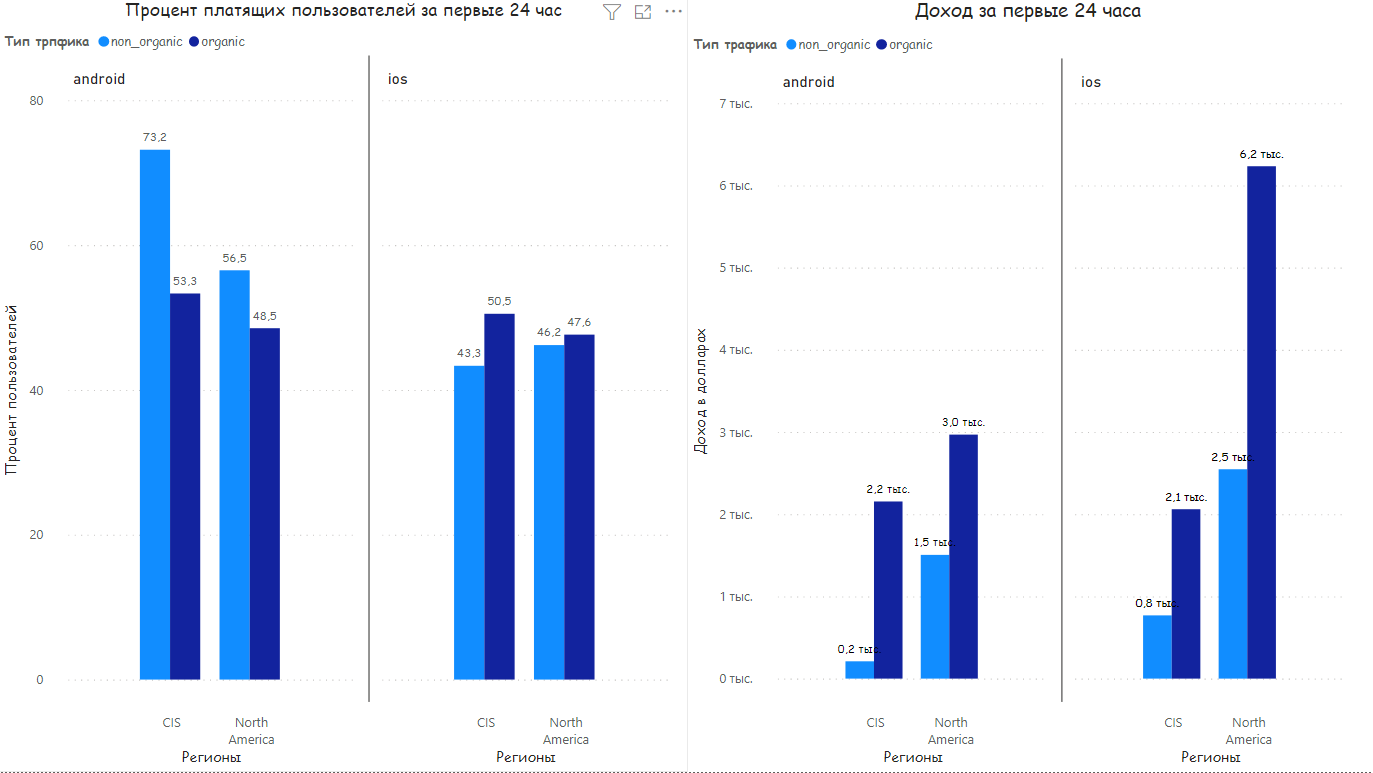

Вывод: На данном графике видно, что процент платящих пользователей выше у андройда (73.2%) и преобладает неорганический трафик, но если присмотреться к доходу за первые 24 часа, то можно заметить, что он в разы выше у органических пользователей на платформе iOS (6.2т). Так же можно заметить, что несмотря на высокий процент платящих у неорганических пользователей, все равно преобладает доход от органических пользователей. Говоря про страны, процент платящих пользователей больше в СНГ, но преобладает доход от пользователей Северной Америки. 

In [ ]:
pd.read_sql(f'''
with data as
(SELECT event_time, user_id, user_type, platform, content_id,
min(event_time) OVER (PARTITION BY user_id) as first_pay,
case when country in ('RU', 'BY','TJ','KG', 'AM', 'AZ', 'UZ') then 'CIS'
when country in ('US', 'CA') then 'North America' else 'other' end as region
FROM data_viz_1068.project_dataset
WHERE user_id in 
        (select user_id
         from data_viz_1068.project_dataset
         where event_name = 'FirstLaunchApp') and event_name = 'af_purchase')
         
SELECT  DISTINCT content_id,count(content_id) as popular_pack, user_type, platform, region
FROM data 
WHERE event_time = first_pay and region != 'other'
GROUP BY content_id, user_type, platform, region
''', con=engine)

In [ ]:
pd.read_sql(f'''
SELECT distinct content_id, avg(revenue_usd) as revenue_usd_avg
FROM data_viz_1068.project_dataset
GROUP BY content_id 
ORDER BY revenue_usd_avg desc
''', con=engine)

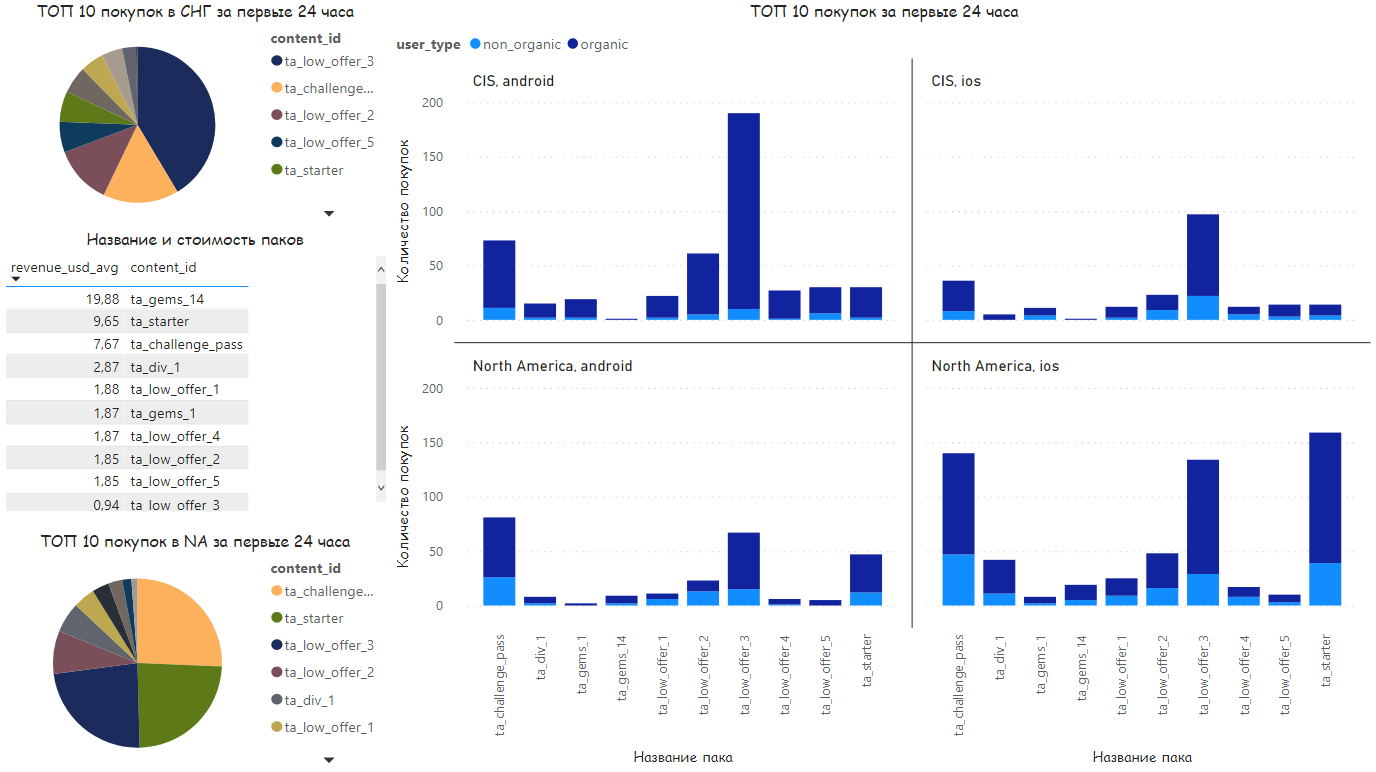

Вывод: В СНГ больше всего покупают "ta_low_offer_3" (один из самых дешевых паков в игре, средняя цена 0.94) на обеих плотформах, в обоих типах трафика. На 2 месте из покупок за первые 24 часа "ta_chelenge_pass" (средняя цена 7.67). Покупка остальных паков из ТОП 10 занимает менее 50% в СНГ. Возможно, что "ta_low_offer_3" - это специальное, акционное предложение, при чем самое дешевое из 5 доступных. Такой большой процент покупок этого пака за первые 24 часа связан с низкой ценой и возможно пользователь хочет опробовать платный контент и проверить на сколько игра станет комфортней. Про "ta_chelenge_pass", можно сказать, что его больше покупают в Северной Америке (26%), почти на равне с "ta_starter" (24%, стоимость 9.65) и "ta_low_offer_3" (23.3 %, стоимость 0.94). Стоит отметить, что первые 2 пака не самые дешеввые из доступных для покупки. Возможно такой выбор связан с выгодностью паков и ограниченностью предложения, а так же может быть связана с покупательской способностью. Например "ta_starter" дает неплохой бонус в начале игры, который поможет быстро развиться, а "ta_chelenge_pass" покупают, потому что дает, какие либо дополнительные ачивки, скины, внутреигровую валюту.